<h2 align="center">Laboratório de Matemática Computacional (LaMaC)</h2>

### Tutorial de Decomposição de Valor Singular (SVD) e Análise de Componentes Principais (PCA)

Neste tutorial veremos o que são a **decomposição de valor singular** e a **análise de componentes principais**, como são calculadas e, também, uma aplicação de PCA no reconhecimento facial.

### O que é SVD?

A Decomposição em Valores Singulares &ndash; *Singular Value Decomposition* (SVD) &ndash; é uma técnica fundamental em álgebra linear e processamento de sinais que consiste na decomposição de uma matriz em três outras matrizes, permitindo representá-la de forma mais simples e informativa. A SVD é o fundamento da PCA.

Para uma matriz $A$ de dimensão $m \times n$, a SVD de $A$ é representada por:

$$ A = U\Sigma V^T, $$

onde:

- $U$ é uma matriz unitária (cujas colunas são vetores ortonomais) de dimensão $m \times m$, e suas colunas são chamadas de *vetores singulares esquerdos;

- $\Sigma$ é uma matriz diagonal $m \times n$ com os **valores singulares** de $A$, ordenados em ordem decrescente na diagonal principal;

- $V^T$ é a transposta de uma matriz unitária de dimensão $n \times n$, e suas colunas são chamadas de *vetores singulares direitos*.

#### Valores singulares

Os valores singulares são os elementos diagonais da matriz $\Sigma$ na SVD de uma matriz $A$. São números não negativos que refletem a importância de cada vetor singular na representação da matriz original.

Eles capturam a **magnitude da variabilidade dos dados originais** em diferentes direções representadas pelos vetores singulares. Valores singulares maiores indicam maior importância na representação da matriz original e, portanto, retêm mais informação sobre a estrutura dos dados.

### O que é PCA?

PCA, ou ACP, são as siglas para Análise de Componentes Principais &ndash; *Principal Component Analysis* &ndash;, que consiste em uma técnica estatística utilizada para reduzir a dimensionalidade dos dados, preservando a maior parte de sua variância.

Essa técnica transforma um conjunto de variáveis correlacionadas em um conjunto de variáveis não correlacionadas, conhecidas como componentes principais. Esses componentes são ordenados de forma descendente, do maior para o menor, com base na sua capacidade de representar a variância dos dados originais. Isso possibilita a extração de um subconjunto dos dados originais que represente mais efetivamente a informação geral, considerando a correlação entre os elementos do conjunto de dados.

A seguir, realizaremos a PCA para reduzir a dimensionalidade dos dados e utilizar apenas as características principais para realizar um reconhecimento facial.

### Base de dados

Utilizaremos a base de dados pública "The ORL Database of Faces" [2], que cosiste em quatrocentas (400) imagens, sendo dez diferentes fotos de cada um de 40 sujeitos distintos. Para alguns sujeitos, as imagens foram capturadas em momentos diferentes, variando a iluminação, expressões faciais (olhos abertos / fechados, sorrindo / não sorrindo) e detalhes faciais (óculos / sem óculos). Todas as imagens foram capturadas em um fundo escuro e homogêneo, com os sujeitos em uma posição frontal e vertical (com tolerância para algum movimento lateral).

Uma prévia das imagens pode ser visualizada abaixo:

![The ORL Database of Faces images preview](assets/orldb.png)

#### Carregando os dados

Inicialmente, vamos carregar os dados originais. Como as imagens são matrizes $112\times92$, vamos vetorizá-las para vetores ($10304\times1$).

In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Informações da base de dados
PATH = "datasets/orl/s{:d}/{:d}.pgm"
linhas = 112
colunas = 92
m = linhas * colunas
num_pessoas = 40
imagens_por_individuo = 10

# Carregando as imagens originais vetorizadas
X_originais = np.empty((1, m))
for d in range(1, num_pessoas + 1):
    for f in range(1, imagens_por_individuo + 1):
        arquivo = PATH.format(d, f)
        img_vetorizada = np.reshape(np.array(mpimg.imread(arquivo)/255.0), (1, m), order='C')
        X_originais = np.vstack((X_originais, img_vetorizada))
X_originais = np.delete(X_originais, 0, 0) # Remove a primeira linha de zeros

#### Separando os dados em treinamento e teste

Agora, vamos separar os dados originais em conjuntos de treinamento e de teste de forma que possamos usar 360 imagens para treinamento e 40 para teste. Então teremos uma base de treino $X_{treino}$ $360\times10304$ e uma base de testes $X_{teste}$ $40\times10304$.

Nosso conjunto alvo (vetor **y**) de treino será o vetor $y_{treino}$ $360\times1$, já o de teste será $y_{teste}$ $40\times1$.

In [55]:
X_treino = np.copy(X_originais)
X_teste = np.zeros((num_pessoas,m))
y_treino = np.zeros((imagens_por_individuo*num_pessoas,), dtype=int)
y_teste = np.zeros((num_pessoas,), dtype=int)

for i in range(num_pessoas):
    X_teste[i,:] = X_originais[imagens_por_individuo*i,:]
    y_teste[i] = i + 1
    y_treino[imagens_por_individuo*i:imagens_por_individuo*(i+1)] = i + 1

for i in range(num_pessoas-1,-1,-1):
    X_treino = np.delete(X_treino, imagens_por_individuo*i, axis=0)
    y_treino = np.delete(y_treino, imagens_por_individuo*i)

print(f"""Dimensões:
    X_treino: {X_treino.shape}
    y_treino: {y_treino.shape}
    X_teste: {X_teste.shape}
    y_teste: {y_teste.shape}
""")

tam_treino = X_treino.shape[0]
tam_teste = X_teste.shape[0]

Dimensões:
    X_treino: (360, 10304)
    y_treino: (360,)
    X_teste: (40, 10304)
    y_teste: (40,)



#### Cálculo do SVD

Antes de tudo, para que possamos calcular corretamente as covariâncias, precisamos subtrair de $X$ suas médias $\mu$.

In [56]:
media_treino = np.reshape( np.mean(X_treino, axis=1), (-1,1) )
X_treino = X_treino - media_treino
media_teste = np.reshape( np.mean(X_teste, axis=1), (-1,1) )
X_teste = X_teste - media_teste

Agora, usamos o módulo de álgebra linear da biblioteca *numpy* para calcular a Decomposição de Valor Singular de $X_{treino}$. As dimensões da decomposição estão reduzidas:

$$
\begin{array}{ccccc}
X & = & U & S & V^T \\
(360 \times 10304) & & (360 \times 360) & (360 \times 360) 
& (360 \times 10304) 
\end{array}
\, .
$$

A matriz $V$, que é igual à matriz dos autovetores da matriz de covariância dos dados $Q$, está sem as colunas correspondentes aos autovetores nulos.

In [57]:
U, S, Vt = np.linalg.svd(X_treino, full_matrices=False)
print('Dimensões: U: ', U.shape, ', S: ', S.shape, ', Vt: ', Vt.shape)

Dimensões: U:  (360, 360) , S:  (360,) , Vt:  (360, 10304)


A **energia acumulada** refere-se à quantidade de informação ou variância dos dados originais que é representada pelos primeiros $k$ valores singulares, onde $k$ é um número escolhido. Ela pode ser calculada por:

$$ \text{Energia} = \frac{\sum^k_{i=1} \sigma^2_i}{\sum^n_{i=1} \sigma^2_i}, $$

onde:

- $\sigma_i$ são os valores singulares ordenados de forma decrescente;

- $k$ é o número de componentes principais considerados;

- $n$ é o total de valores singulares.

A energia acumulada é útil para decidir quantos valores singulares ou componentes principais devem ser mantidos para representar os dados originais de forma eficiente. Quanto maior a energia acumulada, mais informação dos dados originais está sendo preservada pelos primeiros $k$ componentes.

Agora vamos obter os autovalores onde a energia acumulada atinja certo limiar:

Variabilidade acumulada: 83.21%, até o 28-ésimo autovalor.


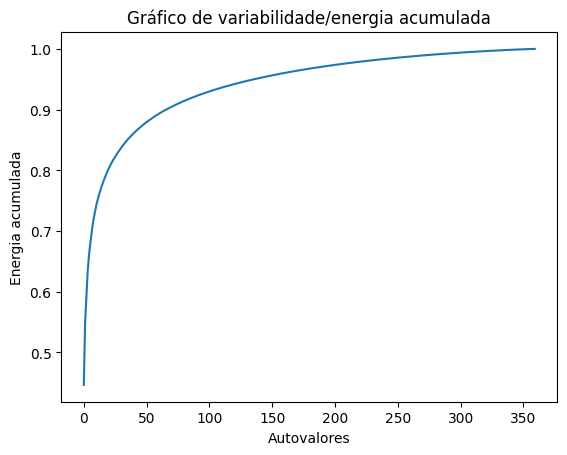

In [58]:
energia = np.cumsum(S**2) / np.sum(S**2)
limiar = 0.83

idx = [ n for n, i in enumerate(energia) if i > limiar ][0]

print(f'Variabilidade acumulada: {round(100*energia[idx], 2)}%, até o {idx}-ésimo autovalor.')
plt.plot(range(len(energia)),energia)
plt.title('Gráfico de variabilidade/energia acumulada')
plt.ylabel('Energia acumulada')
plt.xlabel('Autovalores')
plt.show()

#### Representação por autovetores

Vamos agora tentar visualizar as imagens originais através dos 20 primeiros autovetores de $X_{treino}$, que estão armazenados em $V^T$ (nos vetores singulares direitos).

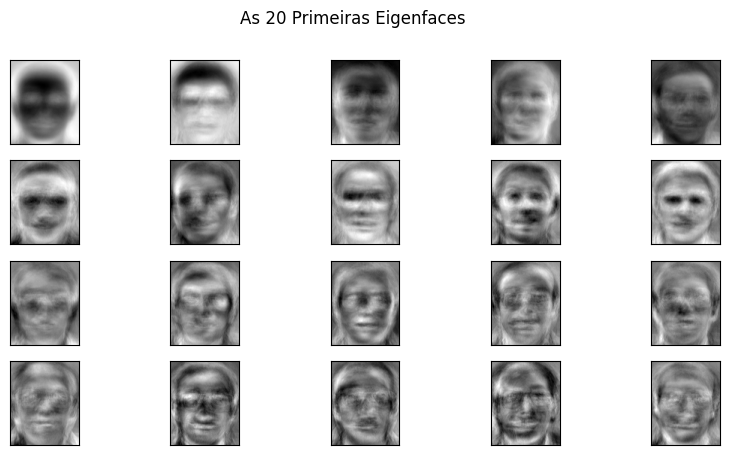

In [59]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('As 20 Primeiras Eigenfaces')

def para_matriz(v, r=linhas, c=colunas):
    return np.reshape( v, (r,c) )

for i in range(20):
    sub = fig.add_subplot(4, 5, i + 1)
    sub.imshow(para_matriz(Vt[i,:]), cmap='gray')
    sub.set_xticks([])
    sub.set_yticks([])
    sub.set_xticklabels([])
    sub.set_yticklabels([])
plt.show()

#### Redução de dimensionalidade

Agora vamos, de fato, reduzir a dimensionalidade dos dados, pegando apenas os $idx$ primeiros autovetores e autovalores:

In [60]:
V_chapeu = Vt[:idx,:].T
Y_treino = np.dot(X_treino, V_chapeu)
Y_teste = np.dot(X_teste, V_chapeu)

print(f"""Dimensões:
    X_treino: {X_treino.shape} -> Y_treino: {Y_treino.shape}
    X_teste: {X_teste.shape} -> Y_teste: {Y_teste.shape}
    V: {Vt.T.shape} -> V_chapeu: {V_chapeu.shape}
""")

Dimensões:
    X_treino: (360, 10304) -> Y_treino: (360, 28)
    X_teste: (40, 10304) -> Y_teste: (40, 28)
    V: (10304, 360) -> V_chapeu: (10304, 28)



#### Precisão do modelo

Vamos agora verificar quão próximos (em distância euclidiana) os dados do nosso modelo reduzido estão dos dados originais

In [61]:
qtd_erros = 0
for i in range(tam_teste):
    dist = []
    for k in range(tam_treino):
        dist = np.append(dist, np.linalg.norm(Y_teste[i,:] - Y_treino[k,:]))
    index = np.argmin(dist)
    if y_treino[index] != y_teste[i]:
        qtd_erros += 1

print(f'Número de erros: {qtd_erros}')
print(f'Acurácia: {100 * (num_pessoas - qtd_erros) / num_pessoas}%')

Número de erros: 1
Acurácia: 97.5%


#### Reconhecimento facial

Agora vamos testar o reconhecimento facial em uma das imagens:

In [62]:
%matplotlib qt
individuo = 7
X_treino_com_media = X_treino + media_treino
X_teste_com_media  = X_teste  + media_teste

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(para_matriz(X_teste_com_media[individuo-1,:]), cmap='gray')
ax1.set_title('Nova Imagem (Teste)')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Imagem Mais Similar')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

dist = []
im = plt.imshow(np.random.randn(linhas,colunas), vmin=0, vmax=1, cmap='gray')
plt.ion()
for k in range(tam_treino):
    dist = np.append(dist, np.linalg.norm(Y_teste[individuo-1,:] - Y_treino[k,:]))
    A = para_matriz(X_treino_com_media[k,:])
    im.set_data(A)
    plt.pause(0.005)
index = np.argmin(dist)
print('Identidade real:     ', individuo, \
      '\nIdentidade estimada: ', y_treino[index], \
      '(índice =', index, '\b)')
im.set_data( para_matriz(X_treino_com_media[index,:]) )
plt.pause(0.005)
plt.ioff()

Identidade real:      7 
Identidade estimada:  7 (índice = 55)


#### Reconhecimento com PCA

Agora vamos usar as imagens com componentes reduzidas para predizer

In [63]:
individuo = 7

Y_treino_com_media = np.dot( U[:,0:idx] * S[0:idx], Vt[0:idx,:] )
Y_teste_com_media  = np.dot( Y_teste, V_chapeu.T )

X_train_show = X_treino + media_treino
X_teste_com_media  = X_teste  + media_teste
Y_treino_com_media = Y_treino_com_media + media_treino
Y_teste_com_media  = Y_teste_com_media + media_teste

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(para_matriz(X_teste[individuo-1,:]), cmap='gray')
ax1.set_title('Nova Imagem (Teste)')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2 = fig.add_subplot(1,4,2)
ax2.imshow(para_matriz(Y_teste_com_media[individuo-1,:]), cmap='gray')
ax2.set_title('Nova Imagem Reduzida')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3 = fig.add_subplot(1,4,3)
ax3.set_title('Imagem Reduzida Mais Similar')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])

dist = []
im = plt.imshow(np.random.randn(linhas,colunas), vmin=0, vmax=1, cmap='gray')
plt.ion()
for k in range(tam_treino):
    dist = np.append(dist, np.linalg.norm(Y_teste[individuo-1,:] - Y_treino[k,:]))
    A = para_matriz(Y_treino_com_media[k,:])
    im.set_data(A)
    plt.pause(0.005)
index = np.argmin(dist)
print('Identidade real:     ', individuo, \
      '\nIdentidade estimada: ', y_treino[index], '(índice =', index, '\b)')
im.set_data( para_matriz(Y_treino_com_media[index,:]) )
plt.pause(0.005)

fig = plt.gcf()
ax4 = fig.add_subplot(1,4,4)
ax4.imshow(para_matriz(X_train_show[index,:]), cmap='gray')
ax4.set_title('Imagem Mais Similar')
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_xticklabels([])
ax4.set_yticklabels([])

plt.show()

Identidade real:      7 
Identidade estimada:  7 (índice = 55)


Gerando os gráficos de acertos

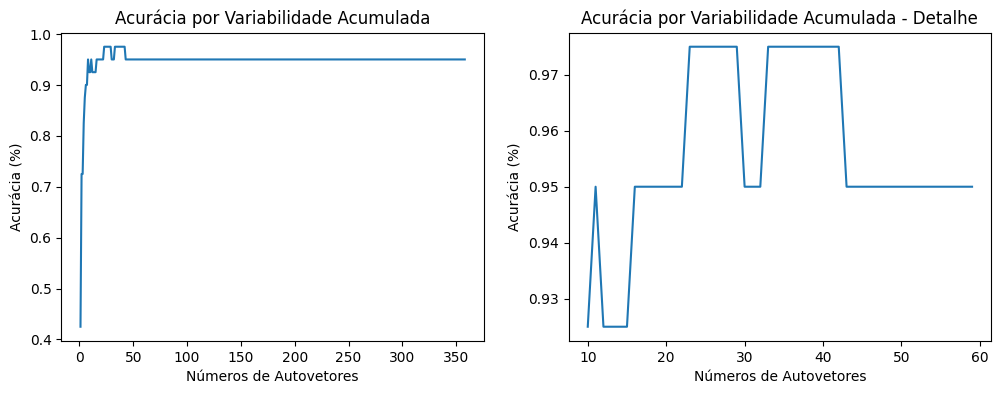

In [64]:
%matplotlib inline

from numba import njit

def principal_components(r):
    V_hat  = Vt[:r,:].T
    Ytrain = U[:,:r] * S[:r]
    Ytest  = np.dot( X_teste,  V_hat )
    return Ytrain, Ytest

@njit(fastmath=True, cache=True)
def find_match(Ytrain, Ytest, ytrain, ytest, ntrains, ntests):
    count = 0
    for i in range(ntests):
        min_dist = 10000
        for j in range(ntrains):
            dist = np.linalg.norm(Ytest[i,:] - Ytrain[j,:])
            if dist <= min_dist:
                index = j
                min_dist = dist
        if ytrain[index] == ytest[i]:
            count += 1
    return count / ntests
           
ntrains = 360
ntests  = 40

acc = []
for r in range(1,360):
    Y_train, Y_test = principal_components(r)
    acc = np.append( acc, \
        find_match(Y_train, Y_test, y_treino, y_teste, ntrains, ntests) )

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Acurácia por Variabilidade Acumulada')
ax1.set_xlabel('Números de Autovetores')
ax1.set_ylabel('Acurácia (%)')
ax1.plot(list(range(1,359)), acc[1:359])

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Acurácia por Variabilidade Acumulada - Detalhe')
ax2.set_xlabel('Números de Autovetores')
ax2.set_ylabel('Acurácia (%)')
ax2.plot(list(range(10,60)), acc[10:60])

plt.show()

### Autores

- Gabriel Furtado Lins Melo

- PhD, Thelmo Pontes de Araujo

### Referências

[1] ARAUJO, T. P. **Álgebra Linear:** Teoria e Aplicações. 1. ed. Rio de Janeiro: SBM, 2014.

[2] AT&T Laboratories Cambridge. The ORL Database of Faces. Disponível em: [https://cam-orl.co.uk/facedatabase.html](https://cam-orl.co.uk/facedatabase.html). **Acesso em:** 30 de novembro de 2023.